In [8]:
import sys
from pathlib import Path
import numpy as np
from scipy.stats import tukey_hsd

project_root = Path.cwd().parent  # or Path().resolve().parent
sys.path.insert(0, str(project_root))

from src.evaluate import evaluate

In [ ]:
import json


# Load the base model data and extract the outputs (model 0)
with open("../data/base_outputs.json", "r", encoding="utf-8") as f:
    model0_data = json.load(f)
#extract the outputs
model0_outputs = []
for i in model0_data:
    model0_outputs.append(i[1])

# load the model only trained on the custom dataset (model 1)
with open("../data/cs_outptus.json", "r", encoding="utf-8") as f:
    model1_data = json.load(f)
#extract the outputs
model1_outputs = []
for i in model1_data:
    model1_outputs.append(i[1])

# load the model trained on the custom and the TL;DR dataset (model 1)
with open("../data/.json", "r", encoding="utf-8") as f:
    model2_data = json.load(f)
#extract the outputs
model2_outputs = []
for i in model2_data:
    model2_outputs.append(i[1])

#load the ground truth / reference data and unpack the outputs
from datasets import Dataset
ref_data = []
with open("../data/custom_dataset.jsonl", "r") as f:
    for line in f:
        ref_data.append(json.loads(line))
#load and do the same split as when we trained
custom_dataset = Dataset.from_dict({
    "messages": [item["messages"] for item in ref_data]
})
split_dataset = custom_dataset.train_test_split(test_size=0.1, seed=42)
test_dataset = split_dataset["test"]

print(f"✓ Loaded {len(test_dataset)} examples")
#Extract the gpt 5.1 outputs
reference = []
for i in test_dataset:
    reference.append(i["messages"][2]["content"])



✓ Loaded 101 examples


In [ ]:
p, r, zeroF1 = evaluate(model0_outputs, reference, device = "mps")
p, r, oneF1 = evaluate(model1_outputs, reference, device = "mps")
p, r, twoF1 = evaluate(model2_outputs, reference, device = "mps")

In [ ]:
zeroF1 = np.array(zeroF1)
oneF1 = np.array(oneF1)
print(np.mean(zeroF1), np.mean(oneF1), np.mean(twoF1))

0.644637 0.69716775


/var/folders/5z/ksmd9z810hv7hd63k2mmtgzr0000gn/T/ipykernel_11866/4018099041.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  zeroF1 = np.array(zeroF1)
/var/folders/5z/ksmd9z810hv7hd63k2mmtgzr0000gn/T/ipykernel_11866/4018099041.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  oneF1 = np.array(oneF1)


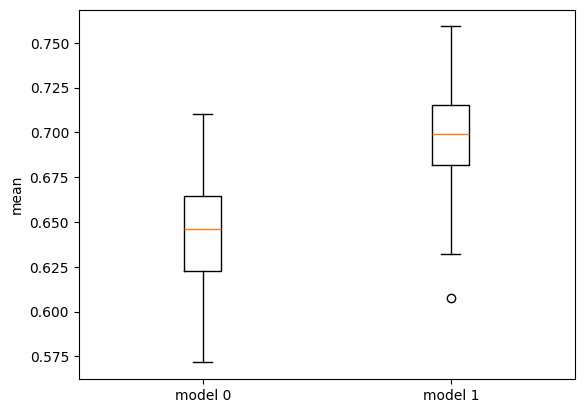

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.boxplot([zeroF1, oneF1, twoF1])
ax.set_xticklabels(["model 0", "model 1", "model 2"]) 
ax.set_ylabel("mean") 
plt.show()

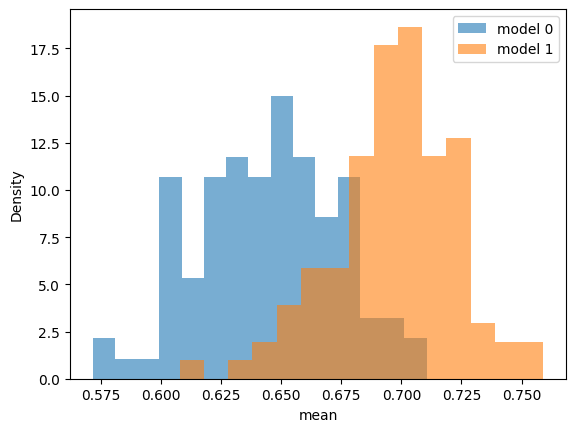

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(zeroF1, bins=15, alpha=0.6, label="Model 0", density=True, ls = "--")
ax.hist(oneF1, bins=15, alpha=0.6, label="Model 1", density=True, ls = "--")
ax.hist(twoF1, bins=15, alpha=0.6, label="Model 2", density=True, ls = "--")

ax.axline(np.mean(zeroF1), color = "b")
ax.axline(np.mean(oneF1), color = "r")
ax.axline(np.mean(twoF1), color = "g")

ax.set_xlabel("mean")
ax.set_ylabel("Density")
ax.legend()

plt.show()


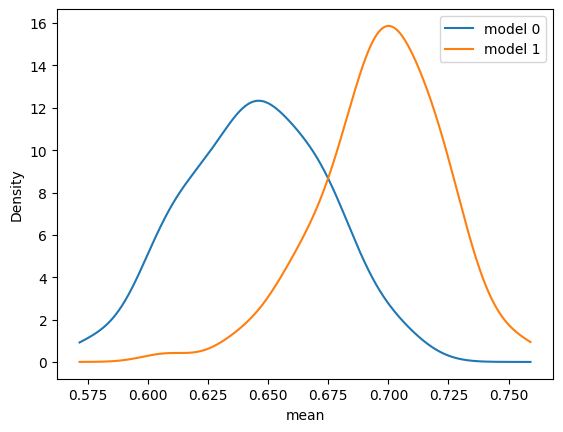

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

fig, ax = plt.subplots()

x = np.linspace(
    min(zeroF1.min(), oneF1.min(),  twoF1.min()),
    max(zeroF1.max(), oneF1.max(), twoF1.max()),
    500
)

ax.plot(x, gaussian_kde(zeroF1)(x), label="model 0")
ax.plot(x, gaussian_kde(oneF1)(x), label="model 1")
ax.plot(x, gaussian_kde(twoF1)(x), label="model 2")

ax.set_xlabel("mean")
ax.set_ylabel("Density")
ax.legend()

plt.show()


In [ ]:
res = tukey_hsd(zeroF1, oneF1, twoF1)
print(res)